## imports ##

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import plotly.subplots as sp
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
#remove warnings
import warnings
warnings.filterwarnings('ignore')

df=pd.read_csv('/Users/gilbenor/Documents/code_projects/msc/counting_research_algorithms/fifty_one/measurements/results/analysis/error_flags_analysis_body_all_mean.csv')
df.head()

,Label,PrawnID,Pond_Type,mean_length,std_length,Length_fov(mm),mean_pixels,pred_Distance_pixels,Length_ground_truth_annotation_pixels,mean_scale,pred_scale
0,full body:undistorted_GX010077_14_237.jpg_gamma,Prawn_0,circle_female,75.624000,3.484291,88.223862,397.144449,475.986860,381.935664,52.616333,53.952168
1,full body:undistorted_GX010077_14_237.jpg_gamma,Prawn_1,circle_female,119.409000,7.534347,130.307259,626.987760,701.859664,703.474985,52.616333,53.861901
2,full body:undistorted_GX010077_14_237.jpg_gamma,Prawn_2,circle_female,104.471333,11.118477,121.385411,551.072805,656.609979,580.506159,52.616333,54.092990
3,full body:undistorted_GX010067_33_625.jpg_gamma,Prawn_0,circle_female,120.649333,11.749097,139.780255,700.400878,748.301965,684.970469,58.258000,53.534168
4,full body:undistorted_GX010067_33_625.jpg_gamma,Prawn_1,circle_female,93.004000,6.587385,102.721787,540.592735,551.039760,531.465367,58.258000,53.643903


## Error decompoition ##

### cancellation magnitude ###


--- Error Analysis for Pond Type: circle_female ---
   - Number of points in df_pond: 92
1. Partial Cancellation of Errors:
   - Percentage of points with partial cancellation: 88.04%

2. Cancellation Magnitude:
   - Mean cancellation magnitude: 9.38
   - Mean percentage of cancellation magnitude relative to Length_fov(mm): 7.35%

3. Dominance of Error Types:
   - Number of points where Scale Error is dominant: 54
   - Percentage of points where Scale Error is dominant: 58.70%
   - Number of points where Pixel Error is dominant: 38
   - Percentage of points where Pixel Error is dominant: 41.30%

----------------------------------------


--- Error Analysis for Pond Type: circle_male ---
   - Number of points in df_pond: 13
1. Partial Cancellation of Errors:
   - Percentage of points with partial cancellation: 100.00%

2. Cancellation Magnitude:
   - Mean cancellation magnitude: 11.68
   - Mean percentage of cancellation magnitude relative to Length_fov(mm): 13.80%

3. Dominance of Err

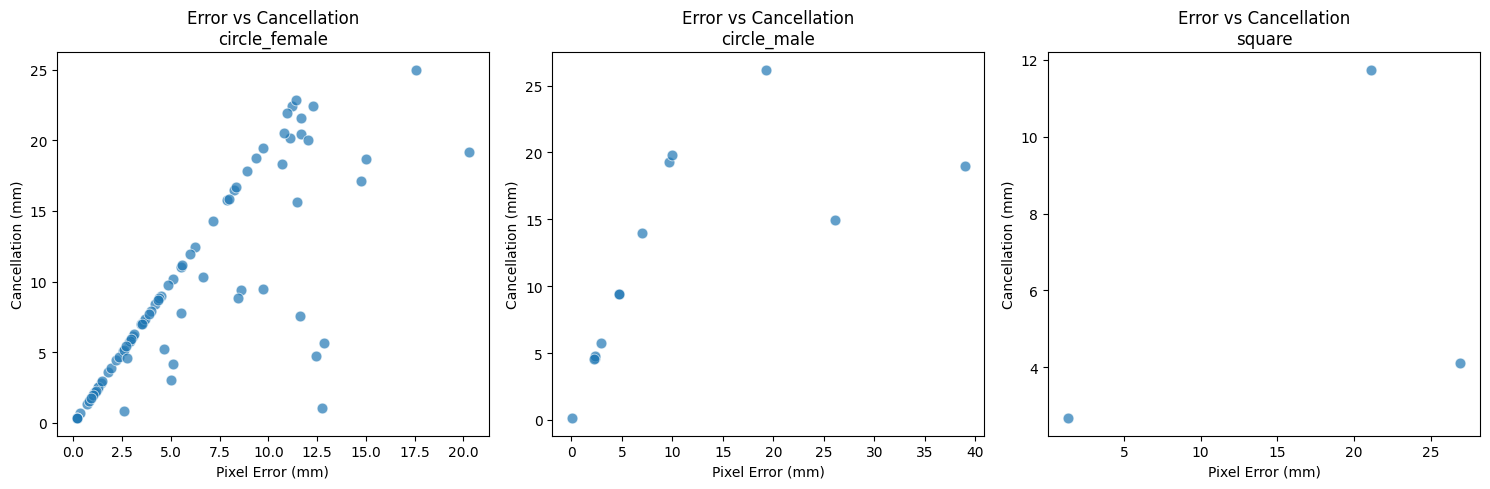

In [11]:
# Get unique pond types
pond_types = df['Pond_Type'].unique()
n_pond_types = len(pond_types)

# Prepare data for all pond types
pond_data = {}
for pond_type in pond_types:
    df_pond = df[df['Pond_Type'] == pond_type]
    df_pond = df_pond.reset_index(drop=True)
    
    mm_per_px_gt   = 10 / df_pond['mean_scale']
    mm_per_px_pred = 10 / df_pond['pred_scale']
    df_pond['pixel_error_mm'] = abs(df_pond['mean_pixels'] - df_pond['pred_Distance_pixels']) * mm_per_px_gt
    df_pond['scale_error_mm'] = df_pond['mean_pixels'] * (mm_per_px_gt - mm_per_px_pred)
    
    partial_cancel_mask_all = (df_pond['pixel_error_mm'] * df_pond['scale_error_mm'] < 0)
    percent_partial_cancel_all = 100 * partial_cancel_mask_all.sum() / len(df_pond) if len(df_pond) > 0 else 0
    
    print("\n--- Error Analysis for Pond Type: {} ---".format(pond_type))
    print("   - Number of points in df_pond: {}".format(len(df_pond)))
    print("1. Partial Cancellation of Errors:")
    print("   - Percentage of points with partial cancellation: {:.2f}%".format(percent_partial_cancel_all))
    
    uncancelled_error = abs(df_pond[partial_cancel_mask_all]['pixel_error_mm']) + abs(df_pond[partial_cancel_mask_all]['scale_error_mm'])
    actual_total_error = abs(df_pond[partial_cancel_mask_all]['pixel_error_mm'] + df_pond[partial_cancel_mask_all]['scale_error_mm'])
    cancellation_magnitude = uncancelled_error - actual_total_error
    
    print("\n2. Cancellation Magnitude:")
    print("   - Mean cancellation magnitude: {:.2f}".format(cancellation_magnitude.mean()))
    print("   - Mean percentage of cancellation magnitude relative to Length_fov(mm): {:.2f}%".format(
        cancellation_magnitude.mean() / df_pond["Length_fov(mm)"].abs().mean() * 100))
    
    df_pond['actual_error_mm'] = abs(df_pond[partial_cancel_mask_all]['pixel_error_mm'] + df_pond[partial_cancel_mask_all]['scale_error_mm'])
    df_pond['cancellation_mm'] = abs(df_pond[partial_cancel_mask_all]['pixel_error_mm']) + abs(df_pond[partial_cancel_mask_all]['scale_error_mm']) - df_pond[partial_cancel_mask_all]['actual_error_mm']
    
    # Calculate the dominance of scale and pixel errors
    df_pond['dominant_error'] = np.where(
        abs(df_pond['scale_error_mm']) > abs(df_pond['pixel_error_mm']),
        'Scale Error',
        'Pixel Error'
    )
    
    dominant_counts = df_pond['dominant_error'].value_counts()
    dominant_percentages = df_pond['dominant_error'].value_counts(normalize=True) * 100
    
    print("\n3. Dominance of Error Types:")
    print("   - Number of points where Scale Error is dominant: {}".format(dominant_counts.get('Scale Error', 0)))
    print("   - Percentage of points where Scale Error is dominant: {:.2f}%".format(dominant_percentages.get('Scale Error', 0)))
    print("   - Number of points where Pixel Error is dominant: {}".format(dominant_counts.get('Pixel Error', 0)))
    print("   - Percentage of points where Pixel Error is dominant: {:.2f}%".format(dominant_percentages.get('Pixel Error', 0)))
    print("\n----------------------------------------\n")
    
    pond_data[pond_type] = df_pond

# Create matplotlib subplots for scatter plots
fig_scatter, axes_scatter = plt.subplots(1, n_pond_types, figsize=(5*n_pond_types, 5))
if n_pond_types == 1:
    axes_scatter = [axes_scatter]

for i, pond_type in enumerate(pond_types):
    df_pond = pond_data[pond_type]
    sns.scatterplot(data=df_pond, x='pixel_error_mm', y='cancellation_mm',
                   alpha=0.7, s=60, ax=axes_scatter[i])
    axes_scatter[i].set_xlabel('Pixel Error (mm)')
    axes_scatter[i].set_ylabel('Cancellation (mm)')
    axes_scatter[i].set_title(f'Error vs Cancellation\n{pond_type}')

plt.tight_layout()
plt.show()

# Create plotly subplots for error components bar plots
fig_bar = make_subplots(
    rows=1, cols=n_pond_types,
    subplot_titles=[f'Error Components - {pond_type}' for pond_type in pond_types],
    shared_yaxes=True
)

for i, pond_type in enumerate(pond_types):
    df_pond = pond_data[pond_type]
    
    # Add Pixel Error bars
    fig_bar.add_trace(
        go.Bar(
            name='Pixel Error' if i == 0 else '',  # Only show legend for first subplot
            x=df_pond.index,
            y=df_pond['pixel_error_mm'],
            marker_color='#1f77b4',
            showlegend=(i == 0),  # Only show legend for first subplot
            hovertemplate="Image: %{customdata[0]}<br>" +
                          "Prawn ID: %{customdata[1]}<br>" +
                          "Mean Length: %{customdata[2]:.1f}mm<br>" +
                          "Model Length: %{customdata[3]:.1f}mm<br>" +
                          "Pixel Error: %{y:.1f}mm<extra></extra>",
            customdata=df_pond[['Label', 'PrawnID', 'mean_length', 'Length_fov(mm)']].values
        ),
        row=1, col=i+1
    )
    
    # Add Scale Error bars
    fig_bar.add_trace(
        go.Bar(
            name='Scale Error' if i == 0 else '',  # Only show legend for first subplot
            x=df_pond.index,
            y=df_pond['scale_error_mm'],
            marker_color='#ff7f0e',
            showlegend=(i == 0),  # Only show legend for first subplot
            hovertemplate="Image: %{customdata[0]}<br>" +
                          "Prawn ID: %{customdata[1]}<br>" +
                          "Mean Length: %{customdata[2]:.1f}mm<br>" +
                          "Model Length: %{customdata[3]:.1f}mm<br>" +
                          "Scale Error: %{y:.1f}mm<extra></extra>",
            customdata=df_pond[['Label', 'PrawnID', 'mean_length', 'Length_fov(mm)']].values
        ),
        row=1, col=i+1
    )

# Update layout for bar plots
fig_bar.update_layout(
    barmode='relative',
    title_text='Error Components Analysis by Pond Type',
    width=400*n_pond_types,
    height=600
)

# Update x-axis titles
for i in range(n_pond_types):
    fig_bar.update_xaxes(title_text='Measurement Index', row=1, col=i+1)

# Update y-axis title for the first subplot only
fig_bar.update_yaxes(title_text='Error (mm)', row=1, col=1)

fig_bar.show()

    


    
    #save the plot


In [3]:
import pyperclip
pyperclip.copy(cap.stdout)     # copies everything that was printed
print("✓ copied {:,} characters".format(len(cap.stdout)))

✓ copied 2,664 characters


### scale error ###


--- Scale Error Analysis for Pond Type: circle_female ---
   - Mean of Scale Error: 8.13%
   - Standard Deviation of Scale Error: 5.25%
Percentage of scale error points that share the same image (Label) with at least one other scale error point (all samples): 23.9130%
Number of scale error points that share the same image (Label) with at least one other scale error point (all samples): 22
Total number of images with shared scale error: 10

----------------------------------------


--- Scale Error Analysis for Pond Type: circle_male ---
   - Mean of Scale Error: 15.10%
   - Standard Deviation of Scale Error: 2.60%
Percentage of scale error points that share the same image (Label) with at least one other scale error point (all samples): 92.3077%
Number of scale error points that share the same image (Label) with at least one other scale error point (all samples): 12
Total number of images with shared scale error: 5

----------------------------------------


--- Scale Error Analysis fo

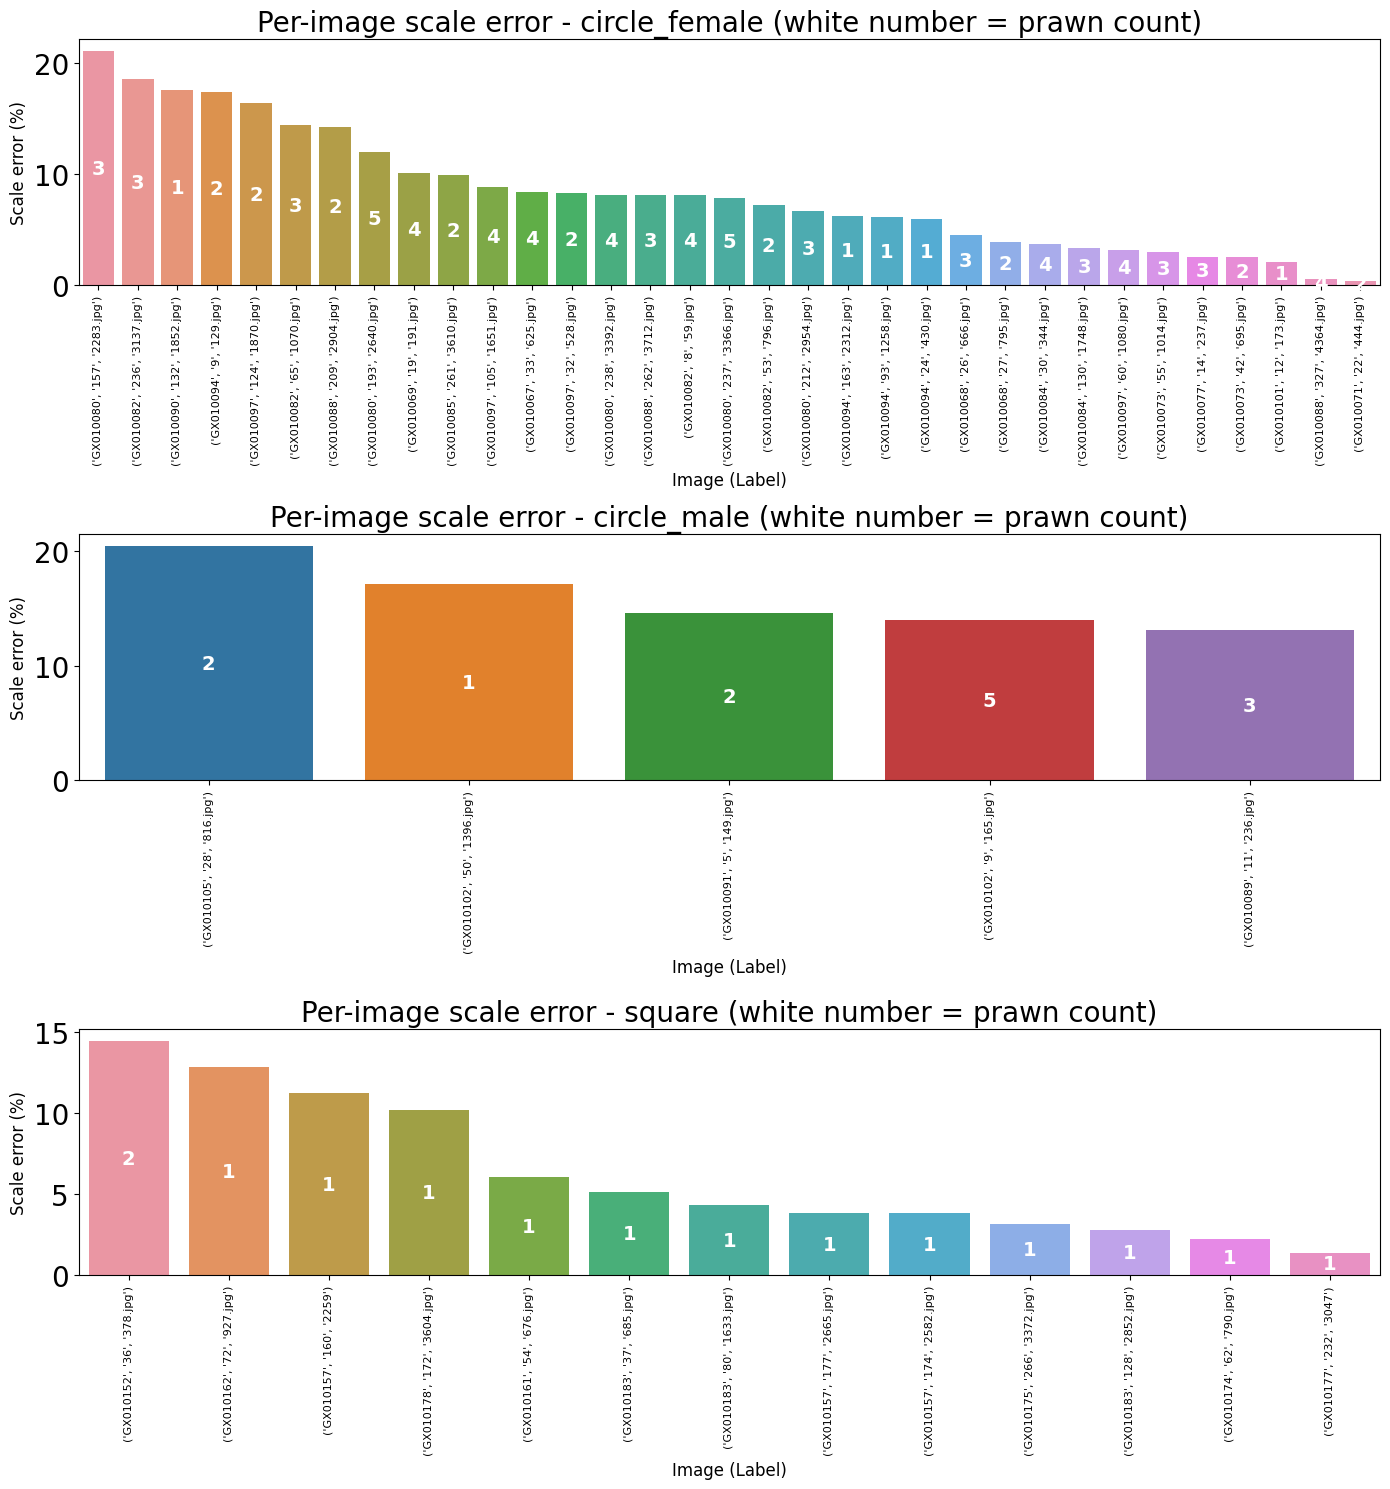

In [12]:

# Get unique pond types and prepare data
pond_types = df['Pond_Type'].unique()
n_pond_types = len(pond_types)

# Prepare data for all pond types
pond_scale_data = {}

for pond_type in pond_types:
    df_pond = df[df['Pond_Type'] == pond_type]
    df_pond['scale_error_mm'] = abs((df_pond['mean_scale'] - df_pond['pred_scale']))/df_pond['mean_scale']*100
    
    # Calculate statistics
    mean_scale_error = df_pond['scale_error_mm'].mean()
    std_scale_error = df_pond['scale_error_mm'].std()
    print(f"\n--- Scale Error Analysis for Pond Type: {pond_type} ---")
    print(f"   - Mean of Scale Error: {mean_scale_error:.2f}%")
    print(f"   - Standard Deviation of Scale Error: {std_scale_error:.2f}%")
    
    # Shared scale error analysis
    shared_label_count = df_pond[df_pond['scale_error_mm'] > 10]['Label'].duplicated(keep=False).sum()
    percent_shared = 100 * shared_label_count / len(df_pond)
    print(f"Percentage of scale error points that share the same image (Label) with at least one other scale error point (all samples): {percent_shared:.4f}%")
    print(f"Number of scale error points that share the same image (Label) with at least one other scale error point (all samples): {shared_label_count}")
    print(f"Total number of images with shared scale error: {df_pond[df_pond['scale_error_mm'] > 10]['Label'].nunique()}")
    print("\n----------------------------------------\n")

    # Group by image
    df_img = (df_pond
            .groupby(
                df_pond['Label'].apply(
                    lambda x: tuple(x.split('undistorted_')[-1].split('_')[0:3])
                )
            )
            .agg(scale_err_perc = ('scale_error_mm', 'mean'),
                prawn_count    = ('scale_error_mm', 'size'))
            .reset_index())

    df_img = df_img.sort_values('scale_err_perc', ascending=False).reset_index(drop=True)
    pond_scale_data[pond_type] = df_img

# Create subplots in 3 rows
fig, axes = plt.subplots(n_pond_types, 1, figsize=(14, 5*n_pond_types))

# Handle case where there's only one pond type
if n_pond_types == 1:
    axes = [axes]

for i, pond_type in enumerate(pond_types):
    df_img = pond_scale_data[pond_type]
    
    # Create bar plot
    sns.barplot(data=df_img, x=df_img.index, y='scale_err_perc', ax=axes[i])
    
    # Add prawn count annotations inside each bar with larger font
    for j, bar in enumerate(axes[i].patches):
        if j < len(df_img):  # Safety check
            count = df_img.loc[j, 'prawn_count']
            height = bar.get_height()
            axes[i].text(
                bar.get_x() + bar.get_width() / 2,   # x = middle of bar
                height / 2,                          # y = halfway up the bar
                str(count),
                ha='center', va='center',
                fontsize=14, color='white', weight='bold'  # Increased from 9 to 14
            )
    
    # Customize each subplot
    axes[i].set_ylabel('Scale error (%)', fontsize=12)
    axes[i].set_xlabel('Image (Label)', fontsize=12)
    axes[i].set_title(f'Per-image scale error - {pond_type} (white number = prawn count)', fontsize=20)
    
    # Make y-axis tick labels bigger
    axes[i].tick_params(axis='y', labelsize=20)
    axes[i].tick_params(axis='x', labelsize=8)
    
    # Set x-tick labels
    axes[i].set_xticks(range(len(df_img)))
    axes[i].set_xticklabels(df_img['Label'], rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

### pixel error ###


--- Analysis for Pond Type: circle_female ---
Percentage of points where the annotation pixel error is smaller (all pixel error samples): 55.4348%
Number of points where the annotation pixel error is smaller (all pixel error samples): 51
Mean pixel error: 37.82 pixels
Mean annotation pixel error: 36.19 pixels
----------------------------------------


--- Analysis for Pond Type: circle_male ---
Percentage of points where the annotation pixel error is smaller (all pixel error samples): 84.6154%
Number of points where the annotation pixel error is smaller (all pixel error samples): 11
Mean pixel error: 55.40 pixels
Mean annotation pixel error: 40.12 pixels
----------------------------------------


--- Analysis for Pond Type: square ---
Percentage of points where the annotation pixel error is smaller (all pixel error samples): 42.8571%
Number of points where the annotation pixel error is smaller (all pixel error samples): 6
Mean pixel error: 67.00 pixels
Mean annotation pixel error: 62.

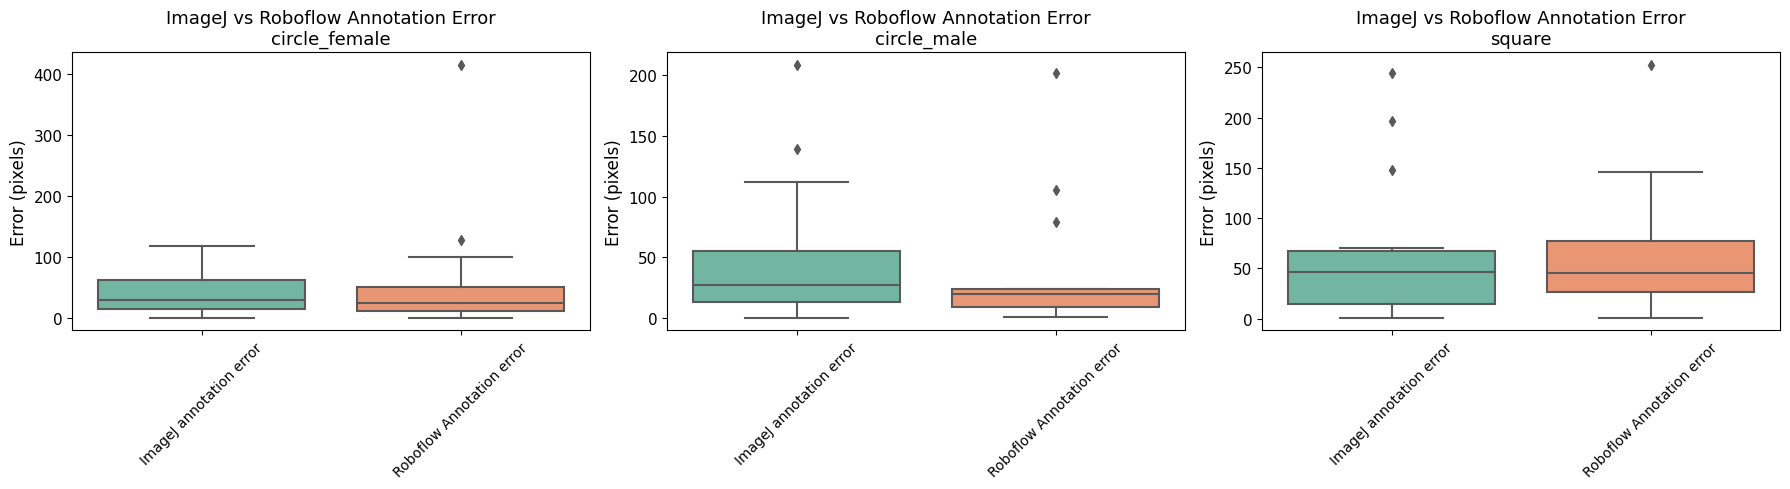

In [13]:
# Get unique pond types and prepare data
pond_types = df['Pond_Type'].unique()
n_pond_types = len(pond_types)

# Prepare data for all pond types
pond_annotation_data = {}

for pond_type in pond_types:
    df_pond = df[df['Pond_Type'] == pond_type]
    df_pond['pixel_error'] = abs(df_pond['mean_pixels'] - df_pond['pred_Distance_pixels'])
    df_pond['annotation_pixel_error'] = abs(df_pond['pred_Distance_pixels'] - df_pond['Length_ground_truth_annotation_pixels'])
    df_pond['annotation_pixel_error_smaller'] = df_pond['annotation_pixel_error'] < abs(df_pond['pixel_error'])
    
    # Print statistics
    print(f"\n--- Analysis for Pond Type: {pond_type} ---")
    print(f"Percentage of points where the annotation pixel error is smaller (all pixel error samples): {df_pond['annotation_pixel_error_smaller'].mean()*100:.4f}%")
    print(f"Number of points where the annotation pixel error is smaller (all pixel error samples): {df_pond['annotation_pixel_error_smaller'].sum()}")
    print(f"Mean pixel error: {df_pond['pixel_error'].mean():.2f} pixels")
    print(f"Mean annotation pixel error: {df_pond['annotation_pixel_error'].mean():.2f} pixels")
    print("----------------------------------------\n")

    # Prepare data for plotting
    df_long = (df_pond[['pixel_error', 'annotation_pixel_error']]
               .rename(columns={'pixel_error': 'ImageJ annotation error', 
                               'annotation_pixel_error': 'Roboflow Annotation error'})
               .melt(var_name='Error_type', value_name='Error_px'))
    
    pond_annotation_data[pond_type] = df_long

# Create subplots in a row (3 columns)
fig, axes = plt.subplots(1, n_pond_types, figsize=(6*n_pond_types, 5))

# Handle case where there's only one pond type
if n_pond_types == 1:
    axes = [axes]

for i, pond_type in enumerate(pond_types):
    df_long = pond_annotation_data[pond_type]
    
    # Create box plot for each pond type
    sns.boxplot(data=df_long, x='Error_type', y='Error_px', palette='Set2', ax=axes[i])
    
    # Customize each subplot
    axes[i].set_ylabel('Error (pixels)', fontsize=12)
    axes[i].set_xlabel('', fontsize=12)
    axes[i].set_title(f'ImageJ vs Roboflow Annotation Error\n{pond_type}', fontsize=13)
    
    # Rotate x-axis labels for better readability
    axes[i].tick_params(axis='x', rotation=45, labelsize=10)
    axes[i].tick_params(axis='y', labelsize=11)

plt.tight_layout()
plt.show()
    

In [14]:
# Get unique pond types and prepare data
pond_types = df['Pond_Type'].unique()
n_pond_types = len(pond_types)

# Prepare data for all pond types
pond_scatter_data = {}

for pond_type in pond_types:
    print(f"Mean length for {pond_type}: {df[df['Pond_Type'] == pond_type]['mean_length'].mean()}")
    print(f"Std length for {pond_type}: {df[df['Pond_Type'] == pond_type]['std_length'].mean()}")
    print(f"Number of prawns in {pond_type}: {len(df[df['Pond_Type'] == pond_type])}")
    
    df_pond = df[df['Pond_Type'] == pond_type]
    min_val = min(df_pond['mean_length'].min(), df_pond['Length_fov(mm)'].min())
    max_val = max(df_pond['mean_length'].max(), df_pond['Length_fov(mm)'].max())
    x = np.linspace(min_val, max_val, 100)
    median_mad = df_pond['std_length'].mean()
    
    # Calculate percentage within bounds for this pond type
    within_bounds = ((df_pond['Length_fov(mm)'] <= df_pond['mean_length'] + median_mad) & 
                    (df_pond['Length_fov(mm)'] >= df_pond['mean_length'] - median_mad)).mean() * 100
    
    pond_scatter_data[pond_type] = {
        'df_pond': df_pond,
        'x': x,
        'median_mad': median_mad,
        'within_bounds': within_bounds
    }

# Create subplots in a row (3 columns)
fig = make_subplots(
    rows=1, cols=n_pond_types,
    subplot_titles=[f' {pond_type}' for pond_type in pond_types],
    shared_yaxes=False
)

# Color palette for different pond types
colors = ['#ff7f0e', '#2ca02c', '#d62728']

for i, pond_type in enumerate(pond_types):
    data = pond_scatter_data[pond_type]
    df_pond = data['df_pond']
    x = data['x']
    median_mad = data['median_mad']
    
    # Add scatter plot
    fig.add_trace(
        go.Scatter(
            x=df_pond['mean_length'],
            y=df_pond['Length_fov(mm)'],
            mode='markers',
            name='Measurements' if i == 0 else '',  # Only show legend for first subplot
            text=df_pond.apply(lambda row: f"Image: {row['Label']}<br>Prawn ID: {row['PrawnID']}", axis=1),
            hoverinfo='text+x+y',
            marker=dict(
                color=colors[i % len(colors)],
                opacity=0.7
            ),
            showlegend=(i == 0)
        ),
        row=1, col=i+1
    )
    
    # Add diagonal line (perfect match)
    fig.add_trace(
        go.Scatter(
            x=x, y=x, 
            mode='lines', 
            name='Perfect match (y=x)' if i == 0 else '', 
            line=dict(color='black', dash='dash'),
            showlegend=(i == 0)
        ),
        row=1, col=i+1
    )
    
    # Add upper boundary
    fig.add_trace(
        go.Scatter(
            x=x, y=x + median_mad, 
            mode='lines', 
            name=f'±Std boundary ({median_mad:.1f} mm)' if i == 0 else '',
            line=dict(color='#2c7fb8', dash='dash'),
            showlegend=(i == 0)
        ),
        row=1, col=i+1
    )
    
    # Add lower boundary
    fig.add_trace(
        go.Scatter(
            x=x, y=x - median_mad, 
            mode='lines',
            name='',  # Don't show in legend (same as upper)
            line=dict(color='#2c7fb8', dash='dash'),
            showlegend=False
        ),
        row=1, col=i+1
    )

# Update layout
fig.update_layout(
    title_text='Model Measurements vs Manual Values with Std Boundaries by Pond Type',
    width=400*n_pond_types,
    height=600,
    showlegend=True
)

# Update x and y axes for each subplot
for i in range(n_pond_types):
    fig.update_xaxes(title_text='Mean of manual measurements (mm)', row=1, col=i+1)
    
# Update y-axis title for the first subplot only
fig.update_yaxes(title_text='Model Measurements (mm)', row=1, col=1)

# Update layout for equal aspect ratio for all subplots
for i in range(n_pond_types):
    fig.update_yaxes(
        scaleanchor=f"x{i+1 if i > 0 else ''}",
        scaleratio=1,
        row=1, col=i+1
    )

fig.show()

Mean length for circle_female: 116.7372862318841
Std length for circle_female: 7.582457260895332
Number of prawns in circle_female: 92
Mean length for circle_male: 77.39110256410257
Std length for circle_male: 5.624595287016238
Number of prawns in circle_male: 13
Mean length for square: 119.58761904761907
Std length for square: 7.729485531879914
Number of prawns in square: 14


In [7]:
for pond_type in df['Pond_Type'].unique():
    #histogram of meAN absolute error
    df_pond = df[df['Pond_Type'] == pond_type]
    df_pond['mean_absolute_error'] =abs(df_pond['mean_length'] - df_pond['Length_fov(mm)'])
    #histogram of mean absolute error    

    #histogram of mean absolute error
    fig = px.histogram(df_pond, x='mean_absolute_error', nbins=100, title=f'Histogram of mean absolute error for {pond_type}')
    fig.show()

In [8]:
from scipy.stats import median_abs_deviation
from pathlib import Path
out_root = Path("/Users/gilbenor/Library/CloudStorage/OneDrive-Personal/phd/"
                "paper/images/final images/body")
out_root.mkdir(parents=True, exist_ok=True)
for pond_type in df['Pond_Type'].unique():
    df_pond = df[df['Pond_Type'] == pond_type]



    mean_scale_per_image=df_pond['mean_scale'].groupby(df_pond['Label']).mean()
    pred_scale_per_image=df_pond['pred_scale'].groupby(df_pond['Label']).mean()


    scale_error_mm=abs((mean_scale_per_image - pred_scale_per_image))/mean_scale_per_image*100
    
    print('--------------------------------')
    print(pond_type)
    print('median',scale_error_mm.median(),'+-',median_abs_deviation(scale_error_mm))
    print('mean',scale_error_mm.mean(),'+-',scale_error_mm.std())

    

    print('--------------------------------')


    #create plotly histogram of scale_error_mm for each pond_type
    fig = px.histogram(scale_error_mm, nbins=100, title=f'Scale Error for {pond_type}')
    #save figure to png to the folder \
    fig.write_image(out_root / f'{pond_type}_scale_error_histogram.png')


--------------------------------
circle_female
median 7.807832365578086 +- 4.106775058561918
mean 8.203101028248422 +- 5.5468613593849625
--------------------------------
--------------------------------
circle_male
median 14.556762602978901 +- 1.4429349406533483
mean 15.827847909661832 +- 2.9561427541917924
--------------------------------
--------------------------------
square
median 4.327627866598123 +- 1.725366215639359
mean 6.285614980324809 +- 4.378281884544316
--------------------------------


## pixel Error ##

In [9]:
from scipy.stats import median_abs_deviation
from pathlib import Path
out_root = Path("/Users/gilbenor/Library/CloudStorage/OneDrive-Personal/phd/"
                "paper/images/final images/body")
out_root.mkdir(parents=True, exist_ok=True)
for pond_type in df['Pond_Type'].unique():
    df_pond = df[df['Pond_Type'] == pond_type]


    pred_distance_pixels=df_pond['pred_Distance_pixels']
    mean_pixels=df_pond['mean_pixels']


    pixel_error_mm=abs((mean_pixels - pred_distance_pixels))/mean_pixels*100
    
    print('--------------------------------')
    print(pond_type)
    print('median',pixel_error_mm.median(),'+-',median_abs_deviation(pixel_error_mm))
    print('mean',pixel_error_mm.mean(),'+-',pixel_error_mm.std())

    

    print('--------------------------------')


    #create plotly histogram of scale_error_mm for each pond_type
    fig = px.histogram(pixel_error_mm, nbins=100, title=f'Pixel Error for {pond_type}')

    #save figure to png to the folder \
    fig.write_image(out_root / f'{pond_type}_pixel_error_histogram.png')

--------------------------------
circle_female
median 4.737012313721348 +- 2.8113553593609497
mean 5.822588800298623 +- 4.545849415137343
--------------------------------
--------------------------------
circle_male
median 5.67057780979981 +- 3.291682391067505
mean 15.504935566363155 +- 20.84191024519792
--------------------------------
--------------------------------
square
median 4.697818771804808 +- 3.7243289287362376
mean 6.840472695145681 +- 7.1167482638395665
--------------------------------


In [10]:
from scipy.stats import median_abs_deviation
from pathlib import Path
out_root = Path("/Users/gilbenor/Library/CloudStorage/OneDrive-Personal/phd/"
                "paper/images/final images/body")
out_root.mkdir(parents=True, exist_ok=True)
for pond_type in df['Pond_Type'].unique():
    df_pond = df[df['Pond_Type'] == pond_type]

    # df_pond['annotation_pixel_error'] = abs(df_pond['pred_Distance_pixels'] - df_pond['Length_ground_truth_annotation_pixels'])

    pred_distance_pixels=df_pond['pred_Distance_pixels']
    mean_pixels=df_pond['Length_ground_truth_annotation_pixels']


    pixel_error_mm=abs((mean_pixels - pred_distance_pixels))/mean_pixels*100
    
    print('--------------------------------')
    print(pond_type)
    print('median',pixel_error_mm.median(),'+-',median_abs_deviation(pixel_error_mm))
    print('mean',pixel_error_mm.mean(),'+-',pixel_error_mm.std())

    

    print('--------------------------------')


    #create plotly histogram of scale_error_mm for each pond_type
    fig = px.histogram(pixel_error_mm, nbins=100, title=f'Pixel Error for {pond_type}')

    #save figure to png to the folder \
    fig.write_image(out_root / f'{pond_type}_pixel__annotation_error_histogram.png')

--------------------------------
circle_female
median 3.796597439666977 +- 2.3408258658434464
mean 6.130523601020218 +- 12.809222990329499
--------------------------------
--------------------------------
circle_male
median 4.035242845762852 +- 2.560592385021737
mean 12.51084617567577 +- 20.17469383421467
--------------------------------
--------------------------------
square
median 4.614606564582114 +- 2.5462711480590654
mean 6.052166946067736 +- 5.434147667252807
--------------------------------
